** IMPORTANT: Update your Imports/ directory! **

Update your Imports directory with these files replacing what you have:

1. Def_RE2NFA.py  - fixed a few lines to generate state names in a new way

2. StateNameSanitizers.py - fixed a few lines to generate state names in a new way

3. Def_DFA.py - fixed comp_dfa which was slightly 'non-kosher'

** IMPORTANT: Now download A4JSoln.ipynb! **

Run all the cells of A4JSoln.ipynb when you do the exercises below. If any crashes, let us know asap. Else
you are good to go.

# Asg4: Context-free Parsing and Derivative Scanning

This Jove file covers two topics. The first, context-free parsing, helps us design a parser for regular expressions. In your assignment, you are to experiment with context-free parsing as well as derivative scanning.

## Context-free Parsing

We will present the parser for regular expressions. We closely follow the conventions set forth by David Beazley, the author of PLY. Please refer to some of the excellent tutorials by Dave at http://www.dabeaz.com/ply/ to further dig into how to design lexing and parsing rules.

We will first strive to support a basic context-free grammar that allows the following types of regular expressions, given by these context-free grammar rules:

R -> Epsilon | char | RR | R+R | (R) | R*

Of course we can't encode this very grammar directly, as it is ambiguous. 

For instance, ab+cd can be parsed as

* (ab) + (cd)
* a (b+c) d
* a (b+(cd))
* ((ab)+c))d

To avoid ambiguity, we layer the grammar in the usual way. We will provide the grammar
finally encoded, below.

We then will try and extend the CFG to support two additional operators:

* The regular expression negation operator, !

* The regular expression conjunction operator, &

The addition of these operators will enrich the grammar to include !R and R&R also as regular expressions.

The final grammar, as generated by 'parser.out' (automatically generated by PLY) is below.

** Note: parser.out is worth studying in depth during a compiler course. ** We won't have the occasion to lead you through it. 

'''

## This is the parser.out file created for our RE CFG:


Created by PLY version 3.4 (http://www.dabeaz.com/ply)

Grammar

Rule 0     S' -> expression

Rule 1     expression -> expression PLUS catexp

Rule 2     expression -> catexp

Rule 3     catexp -> catexp andexp

Rule 4     catexp -> andexp

Rule 5     andexp -> andexp AND ordyexp

Rule 6     andexp -> ordyexp

Rule 7     ordyexp -> ordyexp STAR

Rule 8     ordyexp -> NOT ordyexp

Rule 9     ordyexp -> LPAREN expression RPAREN

Rule 10    ordyexp -> EPS

Rule 11    ordyexp -> STR

Terminals, with rules where they appear

AND                  : 5

EPS                  : 10

LPAREN               : 9

NOT                  : 8

PLUS                 : 1

RPAREN               : 9

STAR                 : 7

STR                  : 11

error                : 

Nonterminals, with rules where they appear

andexp               : 3 4 5

catexp               : 1 2 3

expression           : 1 9 0

ordyexp              : 5 6 7 8

Parsing method: LALR

'''

In [1]:
import sys
sys.path[0:0] = ['../..','../../3rdparty'] # Put these at the head of the search path

from lex import lex
from yacc import yacc
from jove.StateNameSanitizers import ResetStNum, NxtStateStr
from jove.SystemImports       import *

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)



## Token definitions

This is the lexer for REs. We begin with token definitions

In [2]:
tokens = ('EPS','STR','LPAREN','RPAREN','PLUS','STAR', 'NOT', 'AND') # A4J: NOT and AND were commented out before.


# Tokens
t_PLUS    = r'\+'
t_STAR    = r'\*'
t_LPAREN  = r'\('
t_RPAREN  = r'\)'
t_EPS     = r'\'\'|\"\"'   
t_STR     = r'[a-zA-Z0-9]'
t_NOT     = r'\!' # A4J: ADD THE REGULAR EXPRESSION FOR NEGATION HERE
t_AND     = r'\&' # A4J: ADD THE REGULAR EXPRESSION FOR CONJUNCTION HERE

# Ignored characters
t_ignore = " \t"

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")
    
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)
    

# Exercise: Extended CFG for REs

** Q1(a): ** 

Extend the CFG to include "&" and "!", by uncommenting various grammar definition steps, below.

Look for hints marked "A4J" below to uncomment. (This is to make you go through the process in a hand-held way.)

Your answer simply consists of writing below what all you uncommented. You may state what you uncommented, showing the uncommented result, below. Mention why you are uncommenting it (what this new definitions helps with).



** Q1(a) Answer: **

1. Uncommented to include 'NOT' and 'AND' here:

   > tokens = ('EPS','STR','LPAREN','RPAREN','PLUS','STAR', 'NOT', 'AND')
   
2. Uncommented to include these token rules (defined via regular expressions):

   > t_NOT     = r'\!' # A4J: ADD THE REGULAR EXPRESSION FOR NEGATION HERE
   
   > t_AND     = r'\&' # A4J: ADD THE REGULAR EXPRESSION FOR CONJUNCTION HERE

3. Uncommented AND and NOT within the precedence rules:

> precedence = (

>    ('left','PLUS'),

>    ('left', 'AND'),

>    ('left','STAR'),

>    ('right','NOT')

>    )


## These parsing rules specify many things. 

We begin with operator precedence rules that are essentially to help the "LALR parser" (also known as the bottom-up parser) resolve 'shift-reduce conflicts'.

In [3]:
# Parsing rules

# A4J: Suggested new precedence rules for AND and NOT are in comments below.
# Uncomment the AND and NOT lines in your extension
# 
precedence = (
   ('left','PLUS'),
   ('left', 'AND'),  # A4J: AND was not included initially
   ('left','STAR'),
   ('right','NOT')   # A4J: NOT was not included initially
   )

## CFG productions and semantic actions

These Python functions whose names begin with "p_" house (1) the CFG production rules within their documentation strings. (2) the semantic actions within their body. The semantic actions can refer to grammar symbol attributes within CFG productions. We will explain one of these rules now.

Take the rules 

 expression -> expression PLUS catexp
 expression -> catexp
 
1) This function defines the first production rule

def p_expression_plus(t):

   a) This comment string expresses the production rule
   
    '''expression : expression PLUS catexp'''
    
   b) This line below tells us that the occurrence of 'expression' on
      the left-hand side is marked t[0], and its value is determined by
      applying function attrDyadicInfix onto its three arguments below.
      Here, t[1] is the attribute of 'expression' coming after the colon (:)
      and the attribute of catexp is t[3]
      
    t[0] = attrDyadicInfix("+", t[1], t[3])    
    
2) This function expresses the second related production rule where the
   basis case 
    
def p_expression_plus1(t):
    '''expression : catexp'''

    t[0] = t[1]  

In [4]:
def p_expression_plus(t):
    'expression : expression PLUS catexp'
    #
    t[0] = attrDyadicInfix("+", t[1], t[3])    
    
def p_expression_plus1(t):
    'expression : catexp'
    #
    t[0] = t[1]  


def p_expression_cat(t):
    'catexp :  catexp andexp'
    #
    t[0] = attrDyadicInfix(".", t[1], t[2])

def p_expression_cat1(t):
    'catexp :  andexp'
    #
    t[0] = t[1]  

# A4J: The 'andexp AND ordyexp' rule was commented out. 
# We uncommented the same.

def p_expression_ordy(t):
    'andexp : andexp AND ordyexp'
    #
    t[0] = attrDyadicInfix("&", t[1], t[3])


def p_expression_ordy1(t):
    'andexp : ordyexp'
    #
    t[0] = t[1]

# We employ field 'ast' of the dict to record the abstract syntax tree. 
# Field 'dig' holds a digraph. It too is a dict. 
# Its fields are nl for the node list and el for the edge list

def p_expression_ordy_star(t):
    'ordyexp : ordyexp STAR'
    #
    ast = ('*', t[1]['ast'])

    nlin = t[1]['dig']['nl']
    elin = t[1]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("R*_") 
    right = NxtStateStr("*_")

    t[0] = {'ast' : ast,
            'dig' : {'nl' : [root] + nlin + [right], # this order important for proper layout!
                     'el' : elin + [ (root, rootin),
                                     (root, right) ]
                    }}

# A4J: The 'NOT ordyexp' rule was commented out. 
# We uncommented the same.

def p_expression_ordy_not(t):
    'ordyexp : NOT ordyexp'
    #
    ast  = ('!', t[2]['ast'])
    
    nlin = t[2]['dig']['nl']
    elin = t[2]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("!R_") 
    left = NxtStateStr("!_")

    t[0] = {'ast' : ast,
            'dig' : {'nl' : [ root, left ] + nlin, # this order important for proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin) ]
                    }}

    
def p_expression_ordy_paren(t):
    'ordyexp : LPAREN expression RPAREN'
    #
    ast  = t[2]['ast']
    
    nlin = t[2]['dig']['nl']
    elin = t[2]['dig']['el']
    
    rootin = nlin[0]
    
    root = NxtStateStr("(R)_")
    left = NxtStateStr("(_")
    right= NxtStateStr(")_")
    
    t[0] = {'ast' : ast,
            'dig' : {'nl' : [root, left] + nlin + [right], #order important f. proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin),
                                     (root, right) ]
                    }}

def p_expression_ordy_eps(t):
    'ordyexp : EPS'
    #
    strn = '@'
    ast  = ('@', strn)           
    t[0] = { 'ast' : ast,
             'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                      'el' : []
                     }}          
    
def p_expression_ordy_str(t):
    'ordyexp : STR'
    #
    strn = t[1]
    ast  = ('str', strn)
    t[0] = {'ast' : ast,
            'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                     'el' : [] 
                    }}

def p_error(t):
    print("Syntax error at '%s'" % t.value)

#--
    
def attrDyadicInfix(op, attr1, attr3):
    ast  = (op, (attr1['ast'], attr3['ast']))
    
    nlin1 = attr1['dig']['nl']
    nlin3 = attr3['dig']['nl']
    nlin  = nlin1 + nlin3
    
    elin1 = attr1['dig']['el']
    elin3 = attr3['dig']['el']
    elin  = elin1 + elin3
    
    rootin1 = nlin1[0]
    rootin3 = nlin3[0]    
    
    root   = NxtStateStr("R1"+op+"R2"+"_") # NxtStateStr("$_")
    left   = rootin1
    middle = NxtStateStr(op+"_")
    right  = rootin3
    
    return {'ast' : ast,
            'dig' : {'nl' : [ root, left, middle, right ] + nlin,
                     'el' : elin + [ (root, left),
                                     (root, middle),
                                     (root, right) ]
                     }}

#===
# This is the main function in this Jove file. Give
#===

def parseRE(s):
    """In: a string s containing a regular expression.
       Out: An attribute triple consisting of
            1) An abstract syntax tree suitable for processing in the derivative-based scanner
            2) A node-list for the parse-tree digraph generated. Good for drawing a parse tree 
               using the drawPT function below
            3) An edge list for the parse-tree generated (again good for drawing using the
               drawPT function below)
    """
    mylexer  = lex()
    myparser = yacc()
    pt = myparser.parse(s, lexer = mylexer)
    return (pt['ast'], pt['dig']['nl'], pt['dig']['el'])

def drawPT(ast_nl_el, comment="PT"):
    """Given an (ast, nl, el) triple where nl is the node and el the edge-list,
       draw the Parse Tree by returning a dot object.
    """
    (ast, nl, el) = ast_nl_el
    print("Drawing AST for ", ast)
    dotObj_pt = Digraph(comment)
    dotObj_pt.graph_attr['rankdir'] = 'TB'
    for n in nl:
        prNam = n.split('_')[0]
        dotObj_pt.node(n, prNam, shape="oval", peripheries="1")
    for e in el:
        dotObj_pt.edge(e[0], e[1])
    return dotObj_pt

# Exercise: Study of Parsing by Drawing Parse Trees

** Question Q1(b): ** 

Some simple parse-tree examples are now given. 

Please produce __three__ more interesting-looking parser-trees as described, __after you include AND and NOT ( as asked of you in Q1(a))__.

* One parse-tree must include '!' and '*' in one expression. For this, you must try "!!ab**"  and explain the resulting parse tree in terms of whether it is doing the right thing.

 > Comment on the precedences between '!' and concatenation. Also comment on the precedences between '*' and concatentation. Also comment on the associativity of '!' and '*'.

* Another parse-tree must include + and & in one expression. For this, you must try "ab+cd&ef" and explain the resulting parse tree in terms of whether it is doing the right thing.

 > Comment on the precedences between '+' , concatenation, and '&'
 

* A third one can be a complicated RE. However, try to limit yourself to about eight leaf nodes and about the same number of operators (rough guideline only). Write two short sentences describing the parse-tree for your expression, and its choice of operators.

Drawing AST for  ('@', '@')


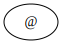

In [5]:
drawPT(parseRE("''"))

Drawing AST for  ('str', '1')


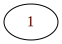

In [6]:
drawPT(parseRE("1"))

Drawing AST for  ('*', ('.', (('*', ('str', '0')), ('*', ('str', '1')))))


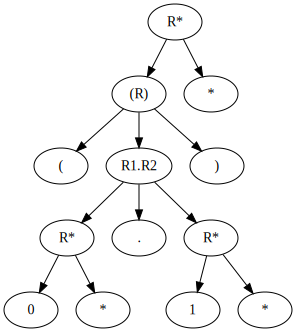

In [7]:
drawPT(parseRE("(0*1*)*"))

** Your answer for Q1(b) below **

Drawing AST for  ('.', (('!', ('!', ('str', 'a'))), ('*', ('*', ('str', 'b')))))


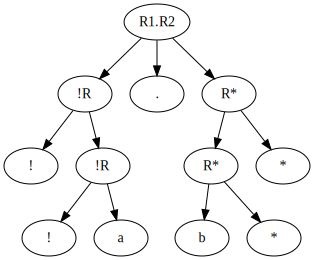

In [8]:
# Demonstrating the parsing of & and + in the same expression

drawPT(parseRE("!!ab**"))

Q1(b): The above parse tree demonstrates how "!" binds tighter than concatenation and is right-associative. It also demonstrates that "*" binds tightly and is left-associative.

Drawing AST for  ('+', (('.', (('str', 'a'), ('str', 'b'))), ('.', (('.', (('str', 'c'), ('&', (('str', 'd'), ('str', 'e'))))), ('str', 'f')))))


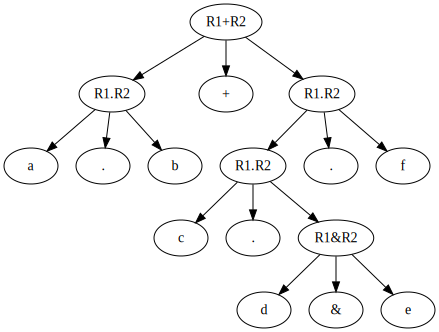

In [9]:
# Demonstrating the parsing of + and & in the same expression. Note that concatenation is also involved

drawPT(parseRE("ab+cd&ef"))

Q1(b): The above parse tree demonstrates how "&" binds the tightest, followed by concatenation, and finally "+"

Drawing AST for  ('+', (('*', ('.', (('str', 'a'), ('str', 'b')))), ('.', (('&', (('!', ('.', (('str', 'c'), ('str', 'd')))), ('str', 'e'))), ('*', ('!', ('str', 'f')))))))


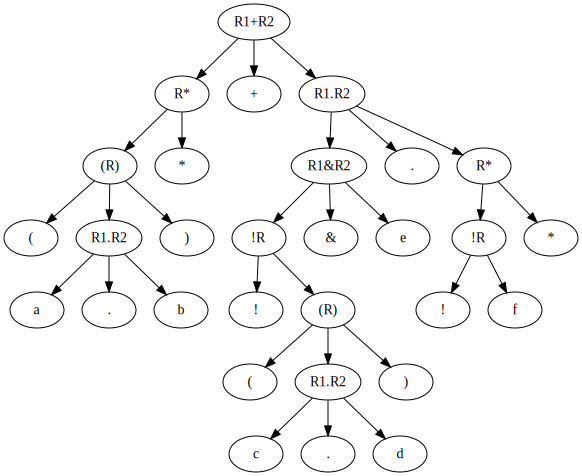

In [10]:
# Demonstrating the parsing of all operators in one RE

drawPT(parseRE("(ab)*+!(cd)&e!f*"))

Q1(b): We simply don't recommend an unreadable RE such as we just now fed. However, some of these REs may be
machine-generated, and then we may not be able to control their length or ugliness. In any case, it appears to
parse exactly as intended!

# Exercise: Produce the Parse Tree for an RE, and Explain 

** Q1(c): ** Draw the parse tree for "0+11*" and explain its shape. Does it implement precedences that you expect "naturally"?

Drawing AST for  ('+', (('str', '0'), ('.', (('str', '1'), ('*', ('str', '1'))))))


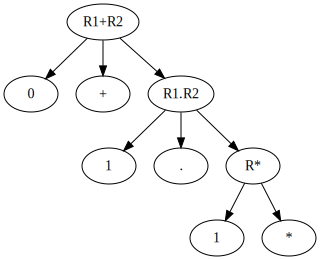

In [11]:
drawPT(parseRE("0+11*"))

** Your answer for Q1(c) here: ** 

We obtained the parse-tree as intended because "*" binds tightly, and after that, concatenation binds tighter than "+"

# Exercise : RE parsing : Precedences

** Q1(d): ** 

Create variants of the expression "0+11*" by putting parentheses, and describe the parse-trees obtained. For example, calling the above RE R1, we have

* R1 = "0+11*"

* R2 = "(0+1)1*" is one variant.

Similarly, produce two other variants, calling them R3 and R4 merely by placing parentheses differently.

* Argue in two clear sentences that R1 through R4 denote different languages

** Your answer for Q1(d) below **

Indeed the parses are different for R1 and R2. In one case, we override the precedence of concatenation by giving "+" higher precedence. We can produce two more parses

* R3 = "0+(11)*"

* R4 = "(0+11)*"

However, our grammar __will not__ produce these parses.

# Produce parse-trees for extended REs

** Q1(e): **  Turn on the parsing rules for "!" and "&". Test the new parser on the following REs

* RE with * and ! : "a!b*"

* RE with & involved : "cd&ef"

* RE with & and + involved : "a+b&c+d"


Drawing AST for  ('.', (('str', 'a'), ('!', ('str', 'b'))))


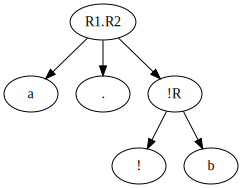

In [12]:
drawPT(parseRE("a!b"))

Drawing AST for  ('.', (('.', (('str', 'c'), ('&', (('str', 'd'), ('str', 'e'))))), ('str', 'f')))


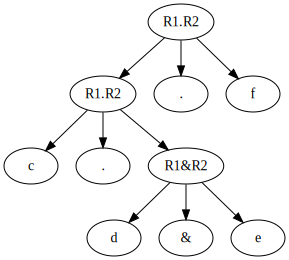

In [13]:
drawPT(parseRE("cd&ef"))

Drawing AST for  ('+', (('+', (('str', 'a'), ('&', (('str', 'b'), ('str', 'c'))))), ('str', 'd')))


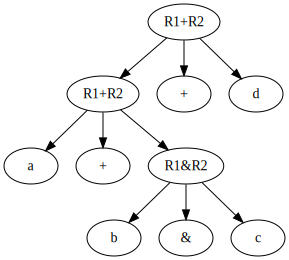

In [14]:
drawPT(parseRE("a+b&c+d"))

** Your answer for Q1(e) below **

The parses were found to be correct

# Derivative-based Pattern Matching

We now present the routines that help implement a derivative-based pattern matcher

In [15]:
#=== Now comes derivMatch as illustration of RE Derivative scanning

# These four functions are simple extractors of the operator and arguments

def opr(E):
    """Retrieves the operator of an expression.
    """
    return E[0]

def arg1(E):
    """Retrieves the first argument of a binary operator-based expression.
    """
    return E[1][0]

def arg2(E):
    """Retrieves the second argument of a binary operator-based expression.
    """
    return E[1][1]

def arg(E):
    """Retrieves the only argument of a unary operator-based expression.
    """
    return E[1]

def nullable(E):
    """This is the nullability test defined in Chapter 10.
    """
    if (opr(E) == "str") :
        return False
    elif (opr(E) == '@') :
        return True
    elif (opr(E) == "mty") :
        return False
    elif (opr(E) == "*"):
        return True
    elif (opr(E) == "!"):
         return not nullable(arg(E))
    elif (opr(E) == '+') :
        return nullable(arg1(E)) or nullable(arg2(E))
    elif (opr(E) == '.') :
        return nullable(arg1(E)) and nullable(arg2(E))
    elif (opr(E) == '&') :
        return nullable(arg1(E)) and nullable(arg2(E))
    else:
        return "???"    

def dv(E, c):
    """This function computes the derivative
       of a regular expression E with respect
       to character "c".
    """
    if (opr(E) == "str") :
        if (arg(E) == c):
            return ('@', '@')
        else:
            return ("mty", "mty")
    elif (opr(E) == '@') :
        return ("mty", "mty")
    elif (opr(E) == "mty") :
        return ("mty", "mty")
    elif (opr(E) == "*"):
        return (".", (dv(arg(E), c), E))
    elif (opr(E) == "!"):
        return ("!", dv(arg(E), c))
    elif (opr(E) == '+') :
        return ("+", (dv(arg1(E), c), dv(arg2(E), c)))
    elif (opr(E) == '&') :
        return ("&", (dv(arg1(E), c), dv(arg2(E), c)))
    elif (opr(E) == '.') :
        if nullable(arg1(E)):
            return ("+", ( ('.', (dv(arg1(E), c), arg2(E))), dv(arg2(E), c) ))
        else:
            return ('.', (dv(arg1(E), c), arg2(E)))
    else:
        return "???"        

def matches(w, E):
    if w=="":
        return nullable(E)
    else:
        derivative = dv(E, w[0])
        return matches(w[1:], derivative)

## Testing Derivative-based Parsing

###  Testing Nullability

A regular expression is nullable if its language contains epsilon.
Regular-expression based pattern-matching works as follows:

* Keep obtaining the derivatives of a given RE under the characters comprising a string

* When the string is empty, check whether the RE is nullable.

In [16]:
(E, nl, el) = parseRE("''")
nullable(E)

True

In [17]:
(E, nl, el) = parseRE("c")
nullable(E)

False

In [18]:
(E, nl, el) = parseRE("c*")
nullable(E)

True

In [19]:
(E, nl, el) = parseRE("!c*")
nullable(E)

True

In [20]:
(E, nl, el) = parseRE("(!c)*")
nullable(E)

True

In [21]:
(E, nl, el) = parseRE("a+b*")
nullable(E)

True

In [22]:
(E, nl, el) = parseRE("a+bb*")
nullable(E)

False

In [23]:
(E, nl, el) = parseRE("a*b*")
nullable(E)

True

In [24]:
(E, nl, el) = parseRE("a*+bb*")
nullable(E)

True

In [25]:
(E, nl, el) = parseRE("aa*+bb*")
nullable(E)

False

### Exercise: Explaining nullability tests

**Q1(f):** Explain the following nullability tests.

In [26]:
(E, nl, el) = parseRE("!a*")
nullable(E)

True

** This is true because !a is starred and the star of any language is nullable. **

Drawing AST for  ('*', ('!', ('str', 'a')))


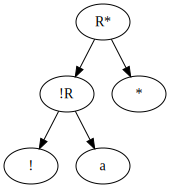

In [27]:
drawPT(parseRE("!a*"))

** The fact that !a is starred is seen from the parse-tree above. **

In [28]:
(E, nl, el) = parseRE("!(a*)")
nullable(E)

False

** It is because "a*" is nullable, and so its complement must not be. **

In [29]:
(E, nl, el) = parseRE("!aa*+b&b*")
nullable(E)

True

Drawing AST for  ('+', (('.', (('!', ('str', 'a')), ('*', ('str', 'a')))), ('&', (('str', 'b'), ('*', ('str', 'b'))))))


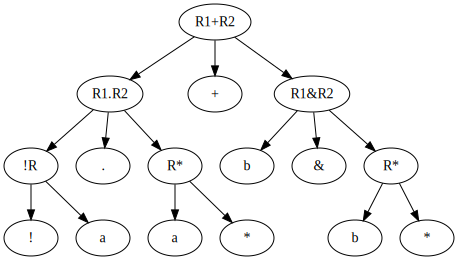

In [30]:
drawPT(parseRE("  !aa*+b&b* "  ))

** Answer: It is because "!a" is nullable and so is "a*". These are concatenated to be the left subexpression 
    of "+" which only cares for one of its 'arms' to be nullable before the whole is declared nullable. **

## Exercise: Explaining nullability tests

**Q1(g):** Explain the following nullability test. Why is it returning true?

In [31]:
(E, nl, el) = parseRE("!a*&b*")
nullable(E)

True

Drawing AST for  ('&', (('*', ('!', ('str', 'a'))), ('*', ('str', 'b'))))


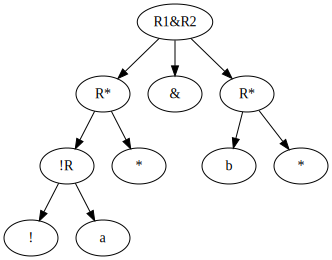

In [32]:
drawPT(parseRE("!a*&b*"))

** Your answer for Q1(g): **

Both the conjuncts are nullable, and so the whole is nullable!

# Pattern-matching tests

** Q1(h): ** Pattern matching

Explain the following outcomes in terms of the behavior of the pattern matcher

In [33]:
re = 'ab'
(E, nl, el) = parseRE(re)
matches("a", E)

False

In [34]:
re = 'ab'
(E, nl, el) = parseRE(re)
matches("ab", E)

True

In [35]:
re = 'a*b*'
(E, nl, el) = parseRE(re)
matches("aabbb", E)

True

Drawing AST for  ('&', (('.', (('*', ('str', 'a')), ('str', 'b'))), ('.', (('str', 'b'), ('*', ('str', 'c'))))))


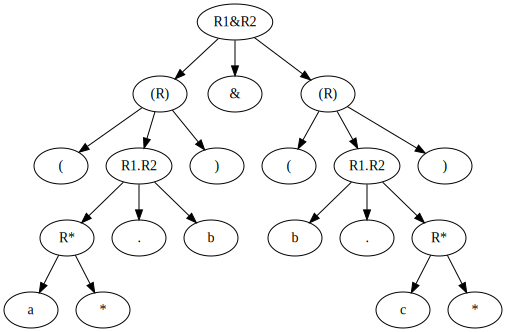

In [36]:
re = '(a*b)&(bc*)'
drawPT(parseRE(re))

In [37]:
re = '(a*b)&(bc*)'
(E, nl, el) = parseRE(re)
matches("b", E)

True


##  Match test answers

re = 'ab'

(E, nl, el) = parseRE(re)

matches("a", E) -> false

** This is justified because the input is "a" while the RE requires "ab", and so the match fails **


re = 'ab'

(E, nl, el) = parseRE(re)

matches("ab", E) -> true

** This is justified because the input is "ab" and the RE requires "ab", and so the match succeeds **


re = 'a*b*'

(E, nl, el) = parseRE(re)

matches("aabbb", E) -> true

** This is justified because the input is "aabbb" and the RE requires "a*b*", and so the match succeeds **


re = '(a*b)&(bc*)'

(E, nl, el) = parseRE(re)

matches("b", E) -> true

** This is justified because the input is "b" and the RE requires "(a*b)(bc*)", and so the match succeeds, as 'b' is common to both languages. **


In [38]:
B1 = "1(0+1)*"

E1 = "(0+1)*1"


B1andE1 =  " ( 1(0+1)* ) & ( (0+1)*1  ) "

NB1orNE1 =  "  !(  ( 1(0+1)* ) & ( (0+1)*1  )    ) "


Drawing AST for  ('.', (('str', '1'), ('*', ('+', (('str', '0'), ('str', '1'))))))


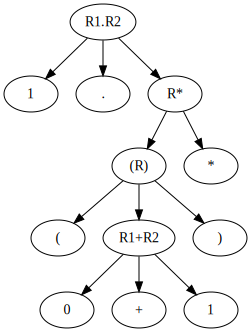

In [39]:
drawPT(parseRE(B1))

Drawing AST for  ('.', (('*', ('+', (('str', '0'), ('str', '1')))), ('str', '1')))


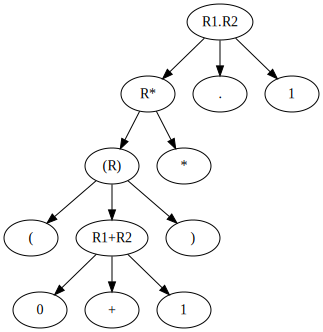

In [40]:
drawPT(parseRE(E1))

Drawing AST for  ('&', (('.', (('str', '1'), ('*', ('+', (('str', '0'), ('str', '1')))))), ('.', (('*', ('+', (('str', '0'), ('str', '1')))), ('str', '1')))))


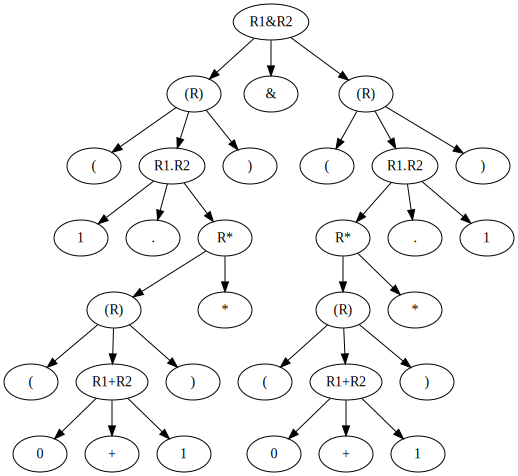

In [41]:
drawPT(parseRE(B1andE1))

In [42]:
NB1orNE1

'  !(  ( 1(0+1)* ) & ( (0+1)*1  )    ) '

Drawing AST for  ('!', ('&', (('.', (('str', '1'), ('*', ('+', (('str', '0'), ('str', '1')))))), ('.', (('*', ('+', (('str', '0'), ('str', '1')))), ('str', '1'))))))


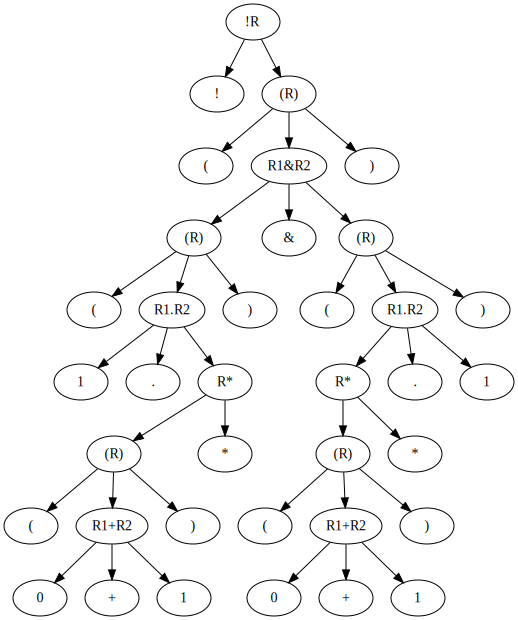

In [43]:
drawPT(parseRE(NB1orNE1))

In [44]:
(E, nl, el) = parseRE(NB1orNE1)

In [45]:
matches("01", E)

True

In [46]:
matches("10", E)

True

In [47]:
matches("00", E)

True

In [48]:
matches("11", E)

False

In [49]:
matches("1010110110", E)

True

In [50]:
matches("1010110111", E)

False

In [51]:
matches("0010110111", E)

True

In [52]:
matches("0010110110", E)

True

** The above four tests reflect the semantics of RE with respect to the DeMorgan's Law. Only when the word does not begin with a 1 or does not end with a 1 must we get a match. In this case, it is evident from the tests. **

# QUESTIONS FOR YOU TO ANSWER

1. Summarize sections 1-8 of this Jove file by answering the following questions. All "sentences" mentioned below are to be around 16 words or so.

 a. (One sentence) how did you add the single-character token "!" into the grammar, ensuring its precedence with respect to "*" ?

 b. (One sentence) how did you add the single-character token "&" into the grammar, ensuring its precedence with respect to "+" ?
 
 c. (One sentence) def p_expression_ordy(t)  and   def p_expression_plus(t)  look the same except for passing "&" or "+" to function attrDyadicInfix. What is the real difference between these functions? Hint: See where in the layered grammar they are situated (and hence what precedence with which they get invoked).
 
 d. (One sentence) How did "!!ab**" get parsed? Indicate by putting parentheses. E.g. if a+b+c got parsed right associative, I would put a+(b+c) in my answer. Like that add parentheses.
 
 e. (One sentence) Without disambiguation, how many parses are there for "0+11" ? Show your answer by putting parentheses.
 
 f. Show that string "aa" is accepted by RE "!aaa". Show all your steps. Hint: Simulate the first 'a'. If you get an empty set, carry on with your work using the rules table.

2. Run the commands embedded in Section 8 of this Jove file. 

 a. Produce an RE capturing 'begins with 1' -- call it B1. Display its parse tree. The commands are waiting above. Run the commands, observe the result. Move on.

 b. Produce an RE capturing 'ends with 1' -- call it E1. Display its parse tree. The commands are waiting above. Run the commands, observe the result. Move on.

 c. Produce an RE capturing B1 and E1. Call this RE B1andE1. Use the "&" operator. Display its parse tree. The commands are waiting above. Run the commands, observe the result. Move on.

 d. Produce an RE capturing the negation of B1andE1. Call this RE NB1orNE1.  Use the "!" operator. Display its parse tree. The commands are waiting above. Run the commands, observe the result. Move on.

 e. Test NB1orNE1 on the following four strings: 00, 01, 10, and 11. Explain the results you obtain. The commands are waiting above. Run the commands, observe the result. Move on.

 e. Repeat for 1010110110, 1010110111, 0010110111, and 0010110110. Explain your results. The commands are waiting above. Run the commands, observe the result. Move on.
 
 f. Clearly explain why matches("0010110110", E)  returns true? Use 3 sentences.
